In [1]:
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

In [2]:
picture_size = 48

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from zipfile import ZipFile
ppp ="/content/drive/MyDrive/archive.zip"

with ZipFile(ppp, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [7]:
train_dataset  = train_datagen.flow_from_directory(directory = 'train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   color_mode = "grayscale",
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [8]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  color_mode = "grayscale",
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [9]:
test_dataset = test_datagen.flow_from_directory(directory = 'test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  color_mode = "grayscale",
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [26]:
#building the model
num_classes = 7
img_rows,img_cols = 48,48
#batch_size = 100




model = Sequential()

# Block-1

model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-2 

model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-3

model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-4 

model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-5

model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-6

model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-7

model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))



In [27]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 activation_27 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_26 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 activation_28 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_27 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                     

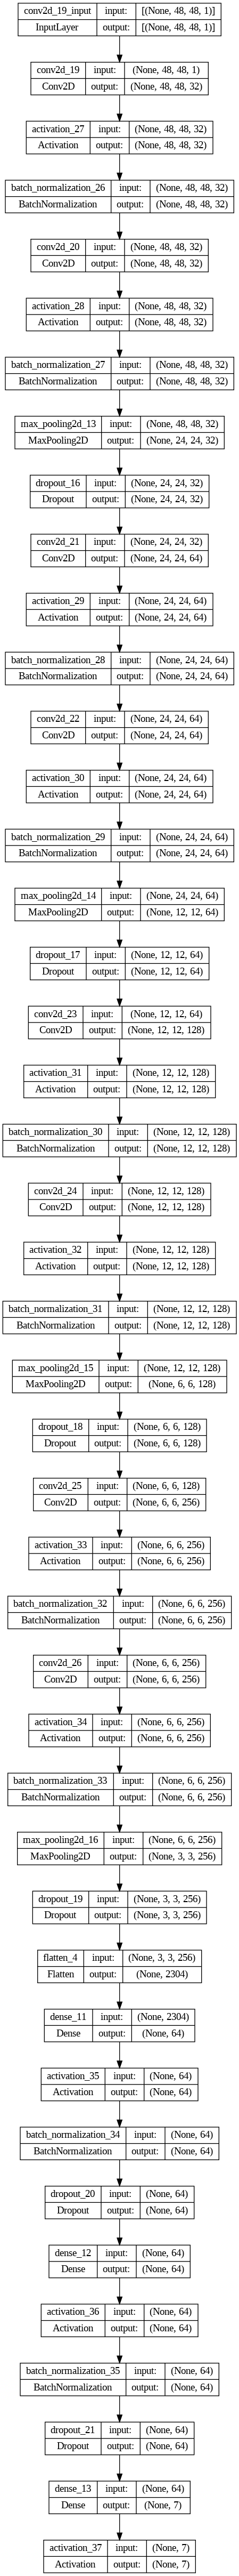

In [28]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [29]:

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [30]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [31]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [32]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [33]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 50,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/50
359/359 [==============================] - 37s 75ms/step - loss: 2.3496 - accuracy: 0.8356 - precision: 0.1904 - recall: 0.0464 - auc: 0.5626 - f1_score: 0.0722 - val_loss: 1.8135 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6598 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/50
359/359 [==============================] - 26s 72ms/step - loss: 1.9119 - accuracy: 0.8532 - precision: 0.2191 - recall: 0.0107 - auc: 0.6317 - f1_score: 0.0201 - val_loss: 1.7901 - val_accuracy: 0.8568 - val_precision: 0.2222 - val_recall: 0.0010 - val_auc: 0.6706 - val_f1_score: 0.0020 - lr: 0.0010
Epoch 3/50
359/359 [==============================] - 25s 70ms/step - loss: 1.8080 - accuracy: 0.8565 - precision: 0.3186 - recall: 0.0041 - auc: 0.6638 - f1_score: 0.0080 - val_loss: 1.7414 - val_accuracy: 0.8573 - val_precision: 0.5676 - val_recall: 0.0037 - val_auc: 0.6983 - val_f1_score: 0.0071 - lr: 0.0010
Epoch 4/50
359/359 [=============================

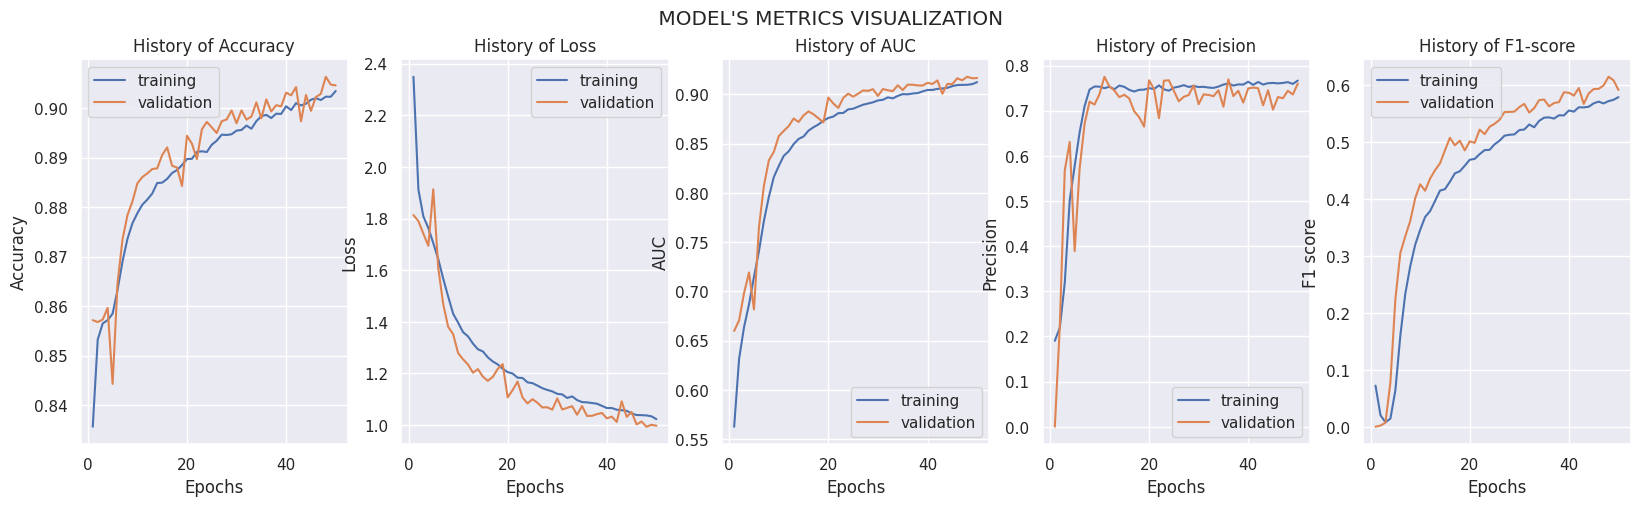

In [34]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [35]:
score = model.evaluate(test_dataset, verbose = 1) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

113/113 [==============================] - 4s 35ms/step - loss: 0.9952 - accuracy: 0.9050 - precision: 0.7598 - recall: 0.4904 - auc: 0.9166 - f1_score: 0.5969
Test loss: 0.9951992034912109
Test accuracy: 0.9050471782684326


In [36]:
predictions = model.predict(test_dataset,verbose=1)
import numpy as np
class_index = test_dataset.classes
pred = predictions.argmax(axis=1)
print(pred)

113/113 [==============================] - 3s 24ms/step
[4 3 6 ... 5 4 5]


In [37]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

print(accuracy_score(class_index,pred))

cm = confusion_matrix(class_index,pred)
print(cm)

0.17316801337419893
[[171   1  57 224 222 195  88]
 [ 20   0   7  23  28  24   9]
 [155   1  89 247 226 175 131]
 [288   1 154 382 406 312 231]
 [198   0 104 240 284 253 154]
 [227   1 105 276 278 222 138]
 [130   2  62 199 184 159  95]]


113/113 [==============================] - 3s 29ms/step


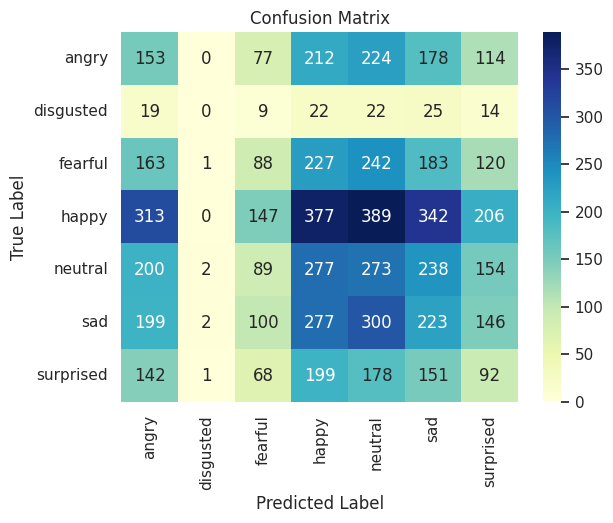

In [38]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
validation_labels = test_dataset.classes
validation_pred_probs = model.predict(test_dataset)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_dataset.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

<ipython-input-39-33d098f4ff76>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


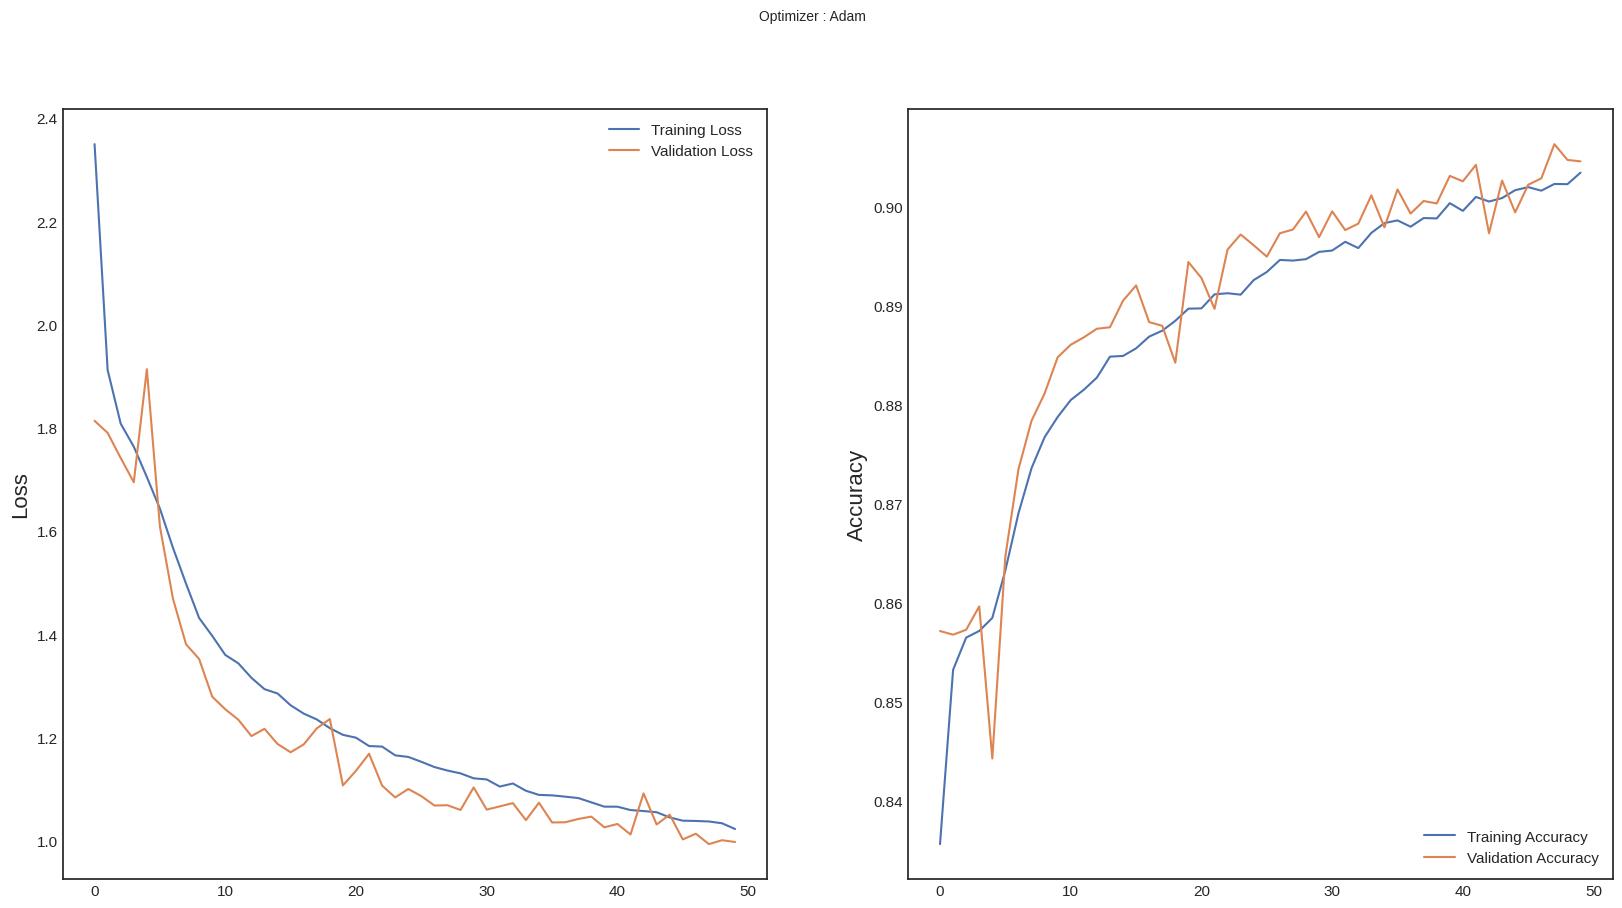

In [39]:
plt.style.use('seaborn-white')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [47]:
model.save('my_model.h5')

In [48]:
Categories = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

In [52]:
import cv2
def prepare(filepath):
    IMG_SIZE = 48
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE) )
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

1/1 [==============================] - 0s 20ms/step
[[0.17443945 0.01015723 0.17181389 0.04573388 0.14853813 0.44294915
  0.00636824]]
Sad
The above expression is:
17.44 %  Angry
1.02 %  Disgust
17.18 %  Fear
4.57 %  Happy
14.85 %  Neutral
44.29 %  Sad
0.64 %  Surprised


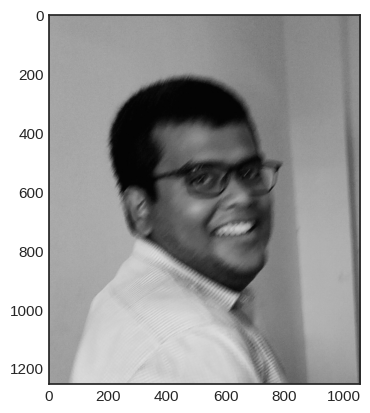

In [77]:
img = plt.imread("sumit.jpg")
plt.imshow(img)
path = "sumit.jpg"
prediction = model.predict(prepare(path)/255)
print(prediction)
label=prediction.argmax()
label
print(Categories[label])
i = 0
print("The above expression is:")
for perc in prediction[0]:
    print(round(perc*100, 2),"% ",Categories[i])
    i+= 1

1/1 [==============================] - 0s 27ms/step


Text(0.5, 1.0, 'Sad')

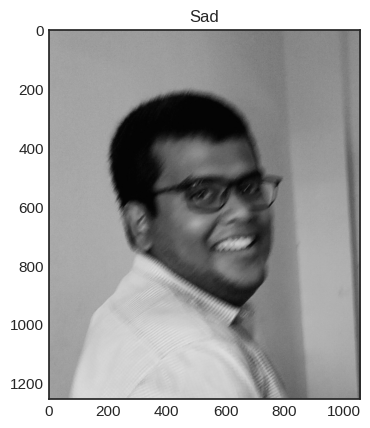

In [78]:
prediction = model.predict(prepare(path)/255)
label = prediction.argmax()
plt.imshow(img)
plt.title(Categories[label])

1/1 [==============================] - 0s 23ms/step
[[0.14267434 0.0078399  0.11293808 0.26390186 0.22397207 0.22930293
  0.01937077]]
Happy
The above expression is:
14.27 %  Angry
0.78 %  Disgust
11.29 %  Fear
26.39 %  Happy
22.4 %  Neutral
22.93 %  Sad
1.94 %  Surprised


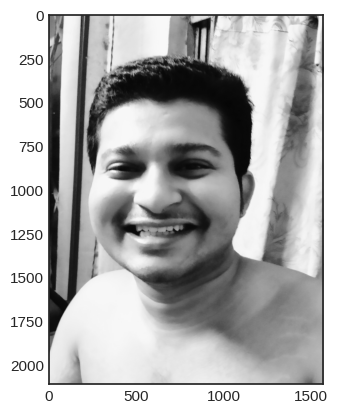

In [82]:
img = plt.imread("manna.jpg")
plt.imshow(img)
path = "manna.jpg"
prediction = model.predict(prepare(path)/255)
print(prediction)
label=prediction.argmax()
label
print(Categories[label])
i = 0
print("The above expression is:")
for perc in prediction[0]:
    print(round(perc*100, 2),"% ",Categories[i])
    i+= 1

1/1 [==============================] - 0s 20ms/step


Text(0.5, 1.0, 'Happy')

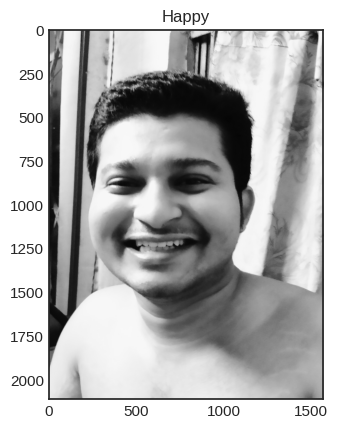

In [83]:
prediction = model.predict(prepare(path)/255)
label = prediction.argmax()
plt.imshow(img)
plt.title(Categories[label])

1/1 [==============================] - 0s 78ms/step
[[0.20184071 0.00854072 0.08573735 0.2829435  0.25418174 0.14013438
  0.02662168]]
Happy
The above expression is:
20.18 %  Angry
0.85 %  Disgust
8.57 %  Fear
28.29 %  Happy
25.42 %  Neutral
14.01 %  Sad
2.66 %  Surprised


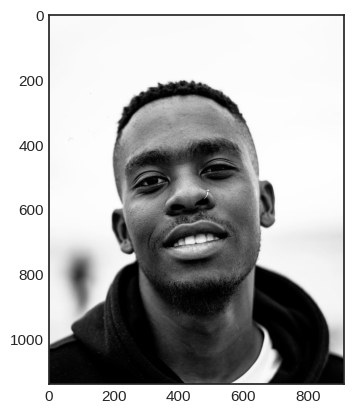

In [79]:
img = plt.imread("photo.jpg")
plt.imshow(img)
path = "photo.jpg"
prediction = model.predict(prepare(path)/255)
print(prediction)
label=prediction.argmax()
label
print(Categories[label])
i = 0
print("The above expression is:")
for perc in prediction[0]:
    print(round(perc*100, 2),"% ",Categories[i])
    i+= 1

1/1 [==============================] - 0s 32ms/step


Text(0.5, 1.0, 'Happy')

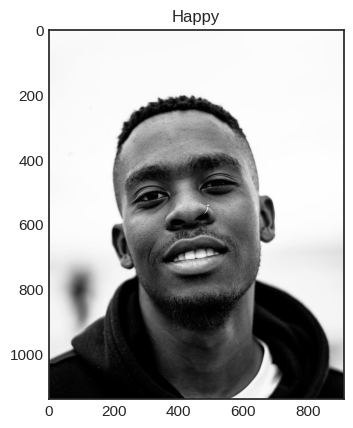

In [80]:
prediction = model.predict(prepare(path)/255)
label = prediction.argmax()
plt.imshow(img)
plt.title(Categories[label])

In [55]:
import matplotlib.pyplot as plt
import shutil
import glob

In [ ]:
file = "Test_Samples\*.jpg"
glob.glob(file)

['E:\\Sem 6\\fer2013\\Test_Samples\\PrivateTest_104142.jpg',
 'E:\\Sem 6\\fer2013\\Test_Samples\\PrivateTest_1054527.jpg',
 'E:\\Sem 6\\fer2013\\Test_Samples\\PrivateTest_1076980.jpg',
 'E:\\Sem 6\\fer2013\\Test_Samples\\PrivateTest_1109992.jpg',
 'E:\\Sem 6\\fer2013\\Test_Samples\\PrivateTest_11895083.jpg',
 'E:\\Sem 6\\fer2013\\Test_Samples\\PrivateTest_1221822.jpg',
 'E:\\Sem 6\\fer2013\\Test_Samples\\PrivateTest_1290484.jpg',
 'E:\\Sem 6\\fer2013\\Test_Samples\\PrivateTest_1338609.jpg',
 'E:\\Sem 6\\fer2013\\Test_Samples\\PrivateTest_1388103.jpg',
 'E:\\Sem 6\\fer2013\\Test_Samples\\PrivateTest_139065.jpg',
 'E:\\Sem 6\\fer2013\\Test_Samples\\PrivateTest_1488292.jpg',
 'E:\\Sem 6\\fer2013\\Test_Samples\\PrivateTest_1623042.jpg',
 'E:\\Sem 6\\fer2013\\Test_Samples\\PrivateTest_1623206.jpg',
 'E:\\Sem 6\\fer2013\\Test_Samples\\PrivateTest_1667417.jpg',
 'E:\\Sem 6\\fer2013\\Test_Samples\\PrivateTest_1673508.jpg',
 'E:\\Sem 6\\fer2013\\Test_Samples\\PrivateTest_1809180.jpg',
 'E:\\Sem

In [ ]:
images = [cv2.imread(image) for image in glob.glob(file)]

In [ ]:
type(images)

list

In [ ]:
len(images)

105

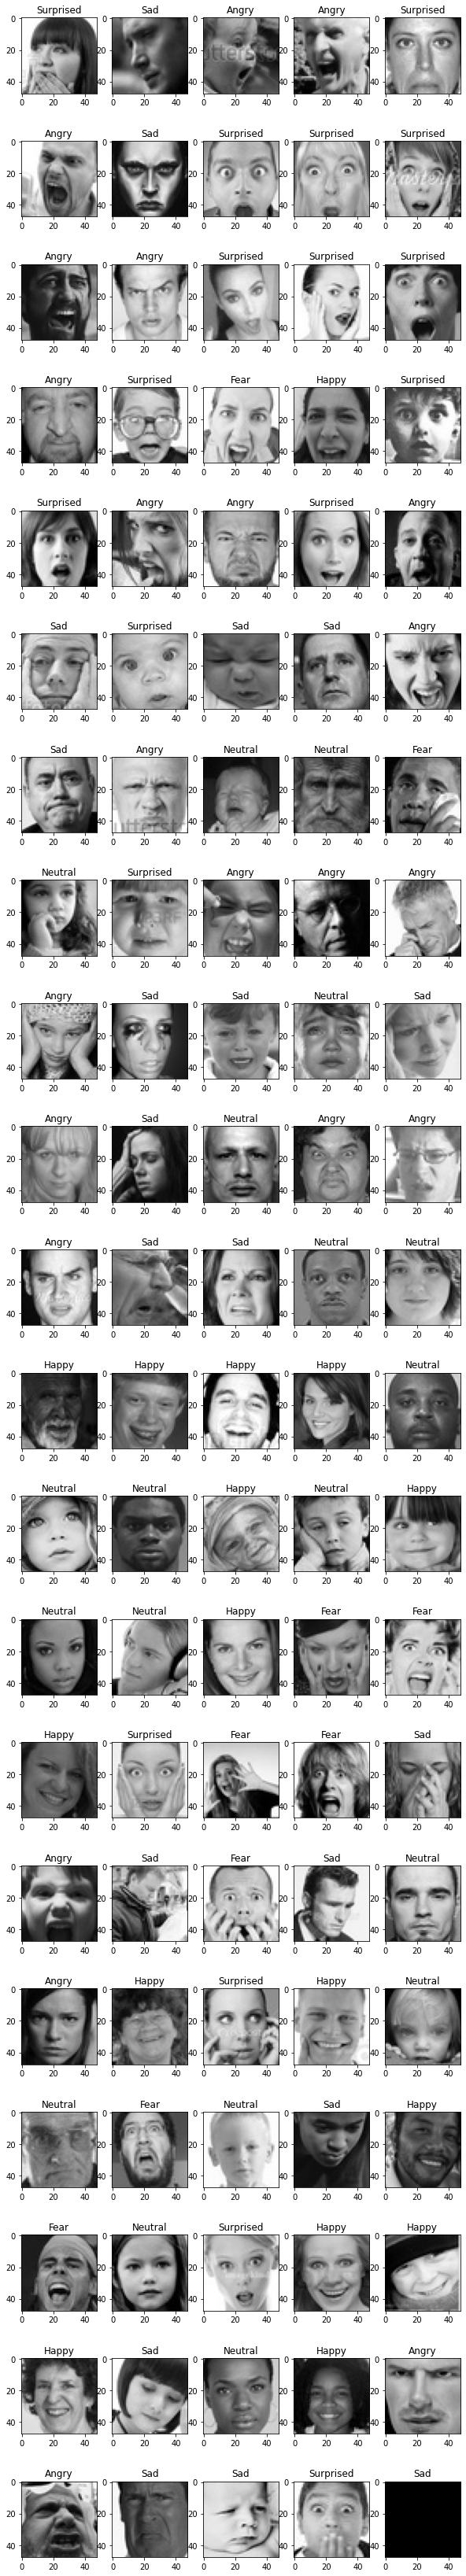

In [ ]:
rows = 21
cols = 5
fig = plt.figure(figsize=(10,60))
for j in range(0,rows*cols):
    fig.add_subplot(rows, cols, j+1)
    plt.imshow(images[j])
    prediction = model.predict(prepare(glob.glob(file)[j])/255)
    label=prediction.argmax()
    plt.title(Categories[label])